# Modeling Phase

In this notebook, we will develop baseline models to predict credit default.
These models will later be audited for explainability, robustness, and compliance.

## Objectives:
- Train baseline models: Logistic Regression, Random Forest, XGBoost.
- Evaluate performance using AUC-ROC, F1-Score and other metrics.
- Save models for future auditing.


In [1]:
# Credit Risk Audit Tool - Modeling Phase
# Dataset: Prosper Loan Data

import sys
import os

# Add the project root to the Python path
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
from audit_tool import modeling as mdl
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

pd.set_option('display.max_columns', None)

# Load Lasso-selected, scaled training and test sets
X_train = pd.read_csv('../data/processed/prosperloan/X_train_lasso.csv')
X_test = pd.read_csv('../data/processed/prosperloan/X_test_lasso.csv')
y_train = pd.read_csv('../data/processed/prosperloan/y_train_lasso.csv').squeeze()
y_test = pd.read_csv('../data/processed/prosperloan/y_test_lasso.csv').squeeze()

print("Lasso-reduced, scaled datasets loaded successfully.")


Lasso-reduced, scaled datasets loaded successfully.


## Logistic Regression
The Logistic Regression model serves as a baseline. 
Its interpretability will also be useful in the explainability phase.


In [6]:
## Logistic Regression (baseline)
# This model serves as a simple interpretable benchmark.
# It will also be useful for explainability techniques (e.g., SHAP, LIME).

from audit_tool import modeling as mdl

# Train model
log_model = mdl.train_logistic_regression(X_train, y_train)

# Predict
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

# Evaluate
from sklearn.metrics import classification_report, roc_auc_score

print("Logistic Regression - Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

auc_lr = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC (test): {auc_lr:.3f}")


Logistic Regression - Classification Report:
              precision    recall  f1-score   support

           0      0.887     0.969     0.927     19386
           1      0.630     0.300     0.406      3402

    accuracy                          0.869     22788
   macro avg      0.759     0.634     0.666     22788
weighted avg      0.849     0.869     0.849     22788

AUC-ROC (test): 0.860


### Test Report: customized threshold por evaluation metrics

Custom threshold set at: 0.3100
Adjusted Classification Report:
              precision    recall  f1-score   support

           0      0.915     0.914     0.914     19386
           1      0.511     0.514     0.512      3402

    accuracy                          0.854     22788
   macro avg      0.713     0.714     0.713     22788
weighted avg      0.854     0.854     0.854     22788



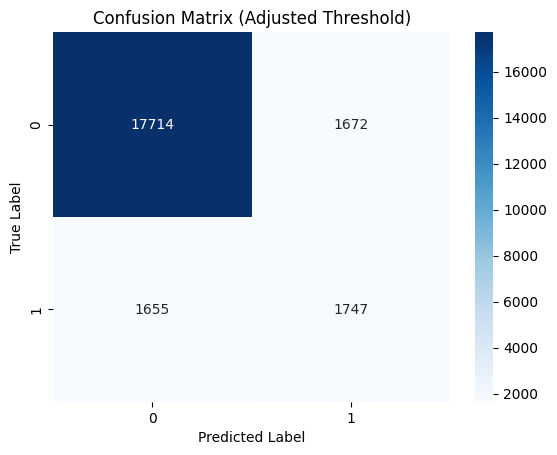

Logistic Regression model saved.


In [7]:
y_prob = log_model.predict_proba(X_test)[:, 1]

threshold = np.quantile(y_prob, 0.85)

y_pred_adjusted = (y_prob >= threshold).astype(int)

# Evaluate with new threshold
from sklearn.metrics import classification_report, confusion_matrix

print(f"Custom threshold set at: {threshold:.4f}")
print("Adjusted Classification Report:")
print(classification_report(y_test, y_pred_adjusted, digits=3))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Adjusted Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Save model
mdl.save_model(log_model, '../models/prosperloan/logistic_regression.pkl')
print("Logistic Regression model saved.")

### Train Report: customized threshold por evaluation metrics

Custom threshold (LogReg, train set, top 15% risky): 0.3204
Train classification report (adjusted threshold):
              precision    recall  f1-score   support

           0      0.912     0.911     0.912     77541
           1      0.497     0.499     0.498     13608

    accuracy                          0.850     91149
   macro avg      0.704     0.705     0.705     91149
weighted avg      0.850     0.850     0.850     91149



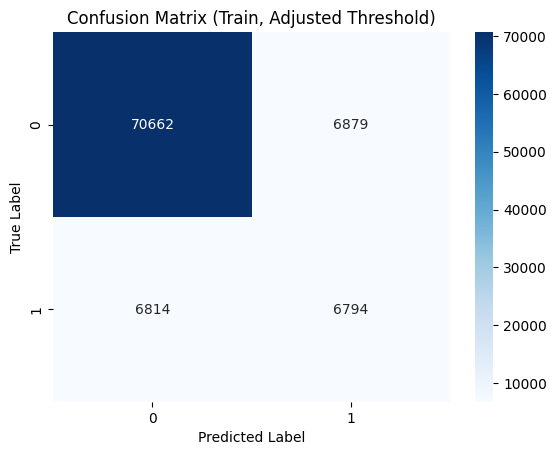

In [10]:
# Get default probabilities on training data
y_prob_train = log_model.predict_proba(X_train)[:, 1]

# Set threshold at 85th percentile (top 15% most risky)
threshold_train = np.quantile(y_prob_train, 0.85)

# Apply custom threshold
y_pred_train_adjusted = (y_prob_train >= threshold_train).astype(int)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
print(f"Custom threshold (LogReg, train set, top 15% risky): {threshold_train:.4f}")
print("Train classification report (adjusted threshold):")
print(classification_report(y_train, y_pred_train_adjusted, digits=3))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_train = confusion_matrix(y_train, y_pred_train_adjusted)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Train, Adjusted Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## Random Forest
The Random Forest model allows us to capture non-linear relationships
and will provide feature importance for explainability.


In [12]:
# Tuning Random Forest (con búsqueda de hiperparámetros y class_weight='balanced')
rf_model = mdl.tune_random_forest(X_train, y_train)

# Evaluación básica (umbral 0.5)
report_rf, auc_rf = mdl.evaluate_model(rf_model, X_test, y_test)
print("Random Forest Report (threshold 0.5):\n", report_rf)
print("AUC:", auc_rf)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


Best Random Forest params: {'class_weight': 'balanced', 'max_depth': None, 'n_estimators': 300}
Random Forest Report (threshold 0.5):
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     19386
           1       0.70      0.22      0.34      3402

    accuracy                           0.87     22788
   macro avg       0.79      0.60      0.63     22788
weighted avg       0.85      0.87      0.84     22788

AUC: 0.8751057903868638


### Test Report: customized threshold por evaluation metrics

In [17]:
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Percentil 90 => top 15%
threshold_rf = np.quantile(y_prob_rf, 0.85)
y_pred_rf_adjusted = (y_prob_rf >= threshold_rf).astype(int)

from sklearn.metrics import classification_report
print(f"Custom threshold (RF, top 15% risky): {threshold_rf:.4f}")
print(classification_report(y_test, y_pred_rf_adjusted, digits=3))

Custom threshold (RF, top 15% risky): 0.3067
              precision    recall  f1-score   support

           0      0.916     0.915     0.916     19386
           1      0.520     0.524     0.522      3402

    accuracy                          0.857     22788
   macro avg      0.718     0.719     0.719     22788
weighted avg      0.857     0.857     0.857     22788



In [14]:
# Guardar modelo ajustado
mdl.save_model(rf_model, '../models/prosperloan/random_forest_tuned.pkl')

### Train Report: customized threshold por evaluation metrics

Custom threshold (RF, train set, top 15% risky): 0.2933
Train classification report (adjusted threshold):
              precision    recall  f1-score   support

           0      1.000     0.999     1.000     77541
           1      0.995     1.000     0.998     13608

    accuracy                          0.999     91149
   macro avg      0.998     1.000     0.999     91149
weighted avg      0.999     0.999     0.999     91149



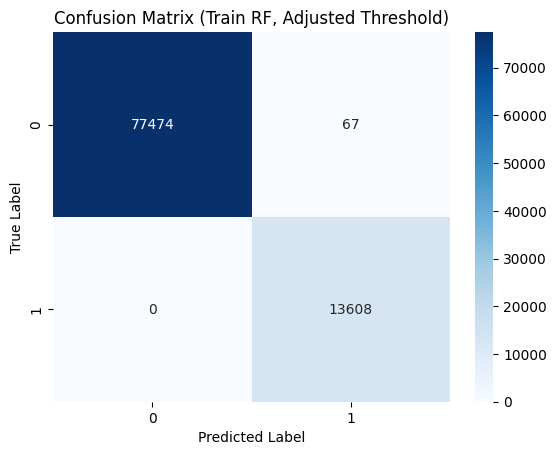

In [15]:
# Get default probabilities on training set
y_prob_rf_train = rf_model.predict_proba(X_train)[:, 1]

# Set threshold at 85th percentile (top 15% most risky)
threshold_rf_train = np.quantile(y_prob_rf_train, 0.85)

# Apply threshold
y_pred_rf_train_adjusted = (y_prob_rf_train >= threshold_rf_train).astype(int)

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

print(f"Custom threshold (RF, train set, top 15% risky): {threshold_rf_train:.4f}")
print("Train classification report (adjusted threshold):")
print(classification_report(y_train, y_pred_rf_train_adjusted, digits=3))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf_train = confusion_matrix(y_train, y_pred_rf_train_adjusted)
sns.heatmap(cm_rf_train, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Train RF, Adjusted Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## XGBoost
XGBoost is often used in financial prediction problems due to its
high performance and flexibility.


In [2]:
from sklearn.model_selection import train_test_split

# Split train into train + validation (e.g. 80% train, 20% val)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Run manual tuning
xgb_model = mdl.tune_xgboost(X_train_sub, y_train_sub, X_val, y_val)

report_xgb, auc_xgb = mdl.evaluate_model(xgb_model, X_test, y_test)
print("XGBoost Report (threshold 0.5):\n", report_xgb)
print("AUC:", auc_xgb)

/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=100, max_depth=3, AUC=0.8739


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=100, max_depth=5, AUC=0.8765


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=100, max_depth=7, AUC=0.8759


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=200, max_depth=3, AUC=0.8764


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=200, max_depth=5, AUC=0.8765


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=200, max_depth=7, AUC=0.8754


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=300, max_depth=3, AUC=0.8773


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=300, max_depth=5, AUC=0.8757


/home/celia/Desktop/tfm-credit-risk-audit/venv/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


n_estimators=300, max_depth=7, AUC=0.8744

Best XGBoost AUC: 0.8773 with params: {'n_estimators': 300, 'max_depth': 3}
XGBoost Report (threshold 0.5):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93     19386
           1       0.67      0.31      0.43      3402

    accuracy                           0.87     22788
   macro avg       0.78      0.64      0.68     22788
weighted avg       0.86      0.87      0.85     22788

AUC: 0.8803462052198253


### Test Report: customized threshold por evaluation metrics

In [4]:
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
threshold_xgb = np.quantile(y_prob_xgb, 0.85)
y_pred_xgb_adjusted = (y_prob_xgb >= threshold_xgb).astype(int)


from sklearn.metrics import classification_report
print(f"Custom threshold (XGB, top 15% risky): {threshold_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb_adjusted, digits=3))

# Guardar modelo
mdl.save_model(xgb_model, '../models/prosperloan/xgboost_tuned.pkl')

Custom threshold (XGB, top 10% risky): 0.3319
              precision    recall  f1-score   support

           0      0.919     0.918     0.918     19386
           1      0.534     0.537     0.535      3402

    accuracy                          0.861     22788
   macro avg      0.726     0.727     0.727     22788
weighted avg      0.861     0.861     0.861     22788



### Train Report: customized threshold por evaluation metrics

In [8]:
# Evaluación sobre el conjunto de entrenamiento
report_train, auc_train = mdl.evaluate_model(xgb_model, X_train, y_train)
print("Train Report (XGBoost):\n", report_train)
print("Train AUC:", auc_train)

Train Report (XGBoost):
               precision    recall  f1-score   support

           0       0.89      0.97      0.93     77541
           1       0.69      0.33      0.45     13608

    accuracy                           0.88     91149
   macro avg       0.79      0.65      0.69     91149
weighted avg       0.86      0.88      0.86     91149

Train AUC: 0.886481869719322


In [16]:
y_prob_train = xgb_model.predict_proba(X_train)[:, 1]

threshold_train = np.quantile(y_prob_train, 0.85)
y_pred_train_adjusted = (y_prob_train >= threshold_train).astype(int)

print(f"Custom threshold (XGB train, top 15% risky): {threshold_train:.4f}")
print("Train classification report (adjusted threshold):")
print(classification_report(y_train, y_pred_train_adjusted, digits=3))

Custom threshold (XGB train, top 15% risky): 0.3380
Train classification report (adjusted threshold):
              precision    recall  f1-score   support

           0      0.921     0.920     0.920     77541
           1      0.545     0.548     0.547     13608

    accuracy                          0.864     91149
   macro avg      0.733     0.734     0.733     91149
weighted avg      0.865     0.864     0.864     91149



All models have been trained and evaluated.
Saved models will be used in the upcoming explainability and robustness audit phases.
